In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jellyfish-types/Train_Test_Valid/valid/Moon_jellyfish/20.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/Moon_jellyfish/60.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/Moon_jellyfish/44.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/Moon_jellyfish/09.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/Moon_jellyfish/15.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/Moon_jellyfish/27.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/blue_jellyfish/22.jpeg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/blue_jellyfish/30.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/blue_jellyfish/35.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/blue_jellyfish/16.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/blue_jellyfish/48.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/blue_jellyfish/05.jpg
/kaggle/input/jellyfish-types/Train_Test_Valid/valid/blue_jellyfish/12.jpeg
/kaggle/input/jellyfish

In [97]:
#code to acquire image dimensions, the dimensions turn out to be highly varied
from PIL import Image
def getImageDimension(path):
    im = Image.open(path)
    width, height = im.size
    return width, height
print(getImageDimension(r"/kaggle/input/jellyfish-types/compass_jellyfish/aug-60-05.jpg"))

(224, 224)


In [98]:
#%matplotlib inline
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, Activation, LeakyReLU, Conv2D, Conv2DTranspose, Input, ReLU
#from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.datasets import mnist
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import Model

In [111]:
# we will resize all the pictures to 64X64 dimensions
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

train_batches = train_datagen.flow_from_directory(
    directory = "/kaggle/input/jellyfish-types" ,
    target_size=(56, 56),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=128,
    shuffle=True)


Found 1879 images belonging to 7 classes.


In [112]:
train_batch=train_batches[5]
print(len(train_batches))
print(train_batch[0].shape)
print(train_batch[1].shape)

15
(128, 56, 56, 3)
(128, 7)


In [113]:
class VAE:
    def __init__(self, batch_size, epochs, train_data):
        self.number_of_rows = 56
        self.number_of_columns = 56
        self.number_of_channels = 3
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.variational_autoencoder = self.build_autoencoder()
        self.batch_size = batch_size
        self.optimizer = keras.optimizers.Adam()
        self.epochs = epochs
        self.reconstruction_loss_weight = 500
        self.train_data = train_data
        self.kl_loss_metric = []
        self.reconstruction_loss_metric = []





    def build_encoder(self):
        input = Input(shape=(self.number_of_rows, self.number_of_columns, self.number_of_channels))
        x = Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
        x = ReLU()(x)
        x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
        x = ReLU()(x)
        x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
        x = ReLU()(x)
        self.shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        z_mean = Dense(2)(x)
        z_log = Dense(2)(x)

        return Model(input, [z_mean, z_log])



    def build_decoder(self):
        input = Input(shape=(2,))
        x = Dense(np.prod(self.shape_before_flattening))(input)
        x = Reshape(self.shape_before_flattening)(x)
        x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(x)
        x = ReLU()(x)
        x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)
        x = ReLU()(x)
        x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
        x = ReLU()(x)
        output = Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation="sigmoid")(x)

        return Model(input, output)




    def sample_from_gaussian(self, inputs):
        z_mean, z_log = inputs
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2))

        return z_mean + tf.exp(z_log / 2) * epsilon



    def build_autoencoder(self):
        input = Input(shape=(self.number_of_rows, self.number_of_columns, self.number_of_channels))
        x = self.encoder(input)
        x = self.sample_from_gaussian(x)
        output = self.decoder(x)

        return Model(input, output)

    def reconstruction_loss(self, input, target): # rms loss

        return tf.math.sqrt(tf.reduce_mean(tf.math.pow(input - target, 2)))


    def KL_loss(self, z_mean, z_log):

        return tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_log - tf.square(z_mean) -tf.exp(z_log)), axis = 1))


    def train_VAE(self):

        self.variational_autoencoder.compile(optimizer="adam")
        
        

        train_dataset = self.train_data
        print("Number of batches in train_dataset:", len(train_dataset))

        for epoch in range(self.epochs):
            kl_loss_temp = []
            reconstruction_loss_temp = []
            total_loss_temp = []
            for i in range(len(train_dataset)):
                train_batch = train_dataset[i]
                batch = train_batch[0]
                with tf.GradientTape() as tape:
                    z_mean, z_log = self.encoder(batch)
                    z = self.sample_from_gaussian([z_mean, z_log])
                    predict = self.decoder(z)
                    reconstruction_loss = self.reconstruction_loss(batch, predict)
                    kl_loss = self.KL_loss(z_mean, z_log)
                    total_loss = self.reconstruction_loss_weight*reconstruction_loss + kl_loss
                  
                grads = tape.gradient(total_loss, self.variational_autoencoder.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.variational_autoencoder.trainable_weights))
                kl_loss_temp.append(kl_loss.numpy())
                reconstruction_loss_temp.append(reconstruction_loss.numpy())
                total_loss_temp.append(total_loss.numpy())

            avg_kl_loss = np.mean(kl_loss_temp)
            avg_reconstruction_loss = np.mean(reconstruction_loss_temp)
            avg_total_loss = np.mean(total_loss_temp)
            self.kl_loss_metric.append(avg_kl_loss)
            self.reconstruction_loss_metric.append(avg_reconstruction_loss)

            print(f"Epoch {epoch + 1}/{self.epochs}, KL Loss: {avg_kl_loss}, Reconstruction Loss: {avg_reconstruction_loss}, Total Loss: {avg_total_loss}")


    

In [114]:
vae = VAE(batch_size=128, epochs=1000, train_data=train_batches)
vae.train_VAE()

Number of batches in train_dataset: 15
Epoch 1/1000, KL Loss: 0.037767067551612854, Reconstruction Loss: 0.30410438776016235, Total Loss: 152.08995056152344
Epoch 2/1000, KL Loss: 1.7296462059020996, Reconstruction Loss: 0.2547012269496918, Total Loss: 129.08026123046875
Epoch 3/1000, KL Loss: 2.7224066257476807, Reconstruction Loss: 0.2246202528476715, Total Loss: 115.03251647949219
Epoch 4/1000, KL Loss: 2.84773325920105, Reconstruction Loss: 0.21778587996959686, Total Loss: 111.74065399169922
Epoch 5/1000, KL Loss: 3.084015369415283, Reconstruction Loss: 0.21309050917625427, Total Loss: 109.6292724609375
Epoch 6/1000, KL Loss: 3.1134440898895264, Reconstruction Loss: 0.21089549362659454, Total Loss: 108.56117248535156
Epoch 7/1000, KL Loss: 3.0761935710906982, Reconstruction Loss: 0.20934008061885834, Total Loss: 107.7462158203125
Epoch 8/1000, KL Loss: 3.1109120845794678, Reconstruction Loss: 0.20707087218761444, Total Loss: 106.64635467529297
Epoch 9/1000, KL Loss: 3.0688683986663

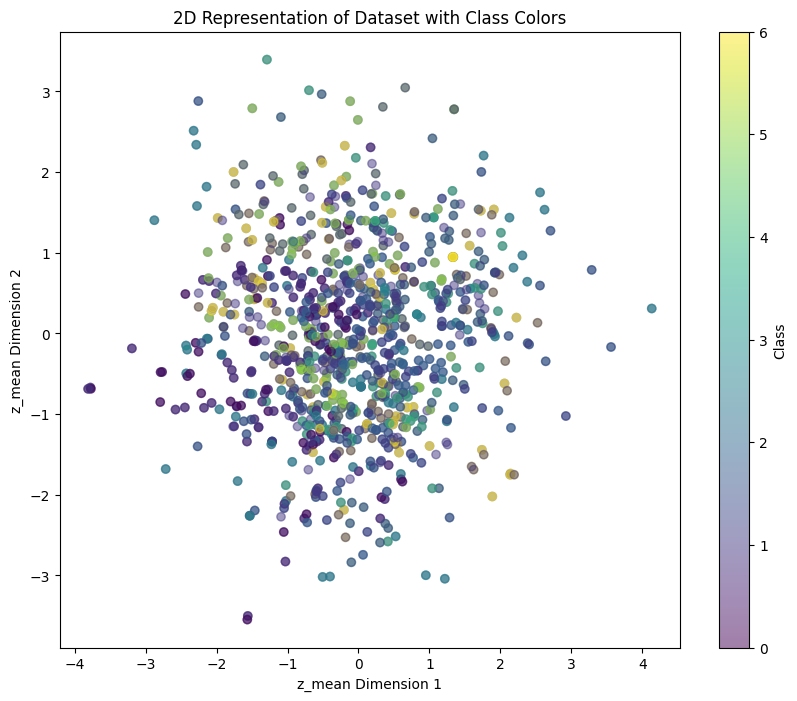

In [118]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def get_z_mean_and_labels(encoder, train_dataset):
    z_mean_values = []
    labels = []
    label_encoder = LabelEncoder()
    for i in range(len(train_dataset)):
        train_batch = train_dataset[i]
        batch = train_batch[0]
        batch_labels = train_batch[1]
        z_mean, _ = encoder(batch)
        z_mean_values.append(z_mean.numpy())
        labels.extend(batch_labels)
    # Flatten the labels array
    labels_flat = np.argmax(labels, axis=1)

    return np.concatenate(z_mean_values, axis=0), label_encoder.fit_transform(labels_flat)

# Get z_mean values and labels for the entire dataset
z_mean_values, class_labels = get_z_mean_and_labels(vae.encoder, train_dataset=train_batches)

# Scatter plot with different colors for each class
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean_values[:, 0], z_mean_values[:, 1], c=class_labels, cmap='viridis', alpha=0.5)
plt.title('2D Representation of Dataset with Class Colors')
plt.xlabel('z_mean Dimension 1')
plt.ylabel('z_mean Dimension 2')

# Add colorbar to show class-color mapping
plt.colorbar(scatter, label='Class')

plt.show()

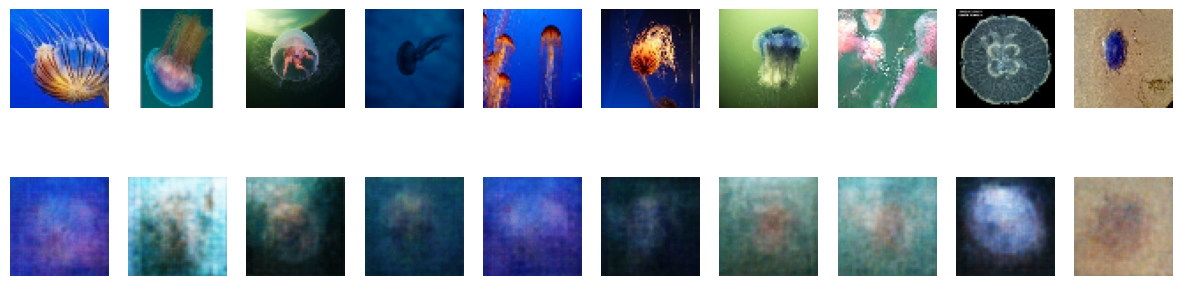

In [119]:
#reconstruction of images
def reconstruct_random_images(test_images, num_samples):

    indices = [1,2,3,4,5,6,7,8,9,0]
    original_images = test_images[indices]

    # Encode and decode the selected samples
    z_mean, z_log = vae.encoder(original_images)
    z = vae.sample_from_gaussian([z_mean, z_log])
    reconstructed_images = vae.decoder(z)

    # Plot the original and reconstructed images
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        axes[0, i].imshow(original_images[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i])
        axes[1, i].axis('off')

    plt.show()

reconstruct_random_images(test_images = train_dataset[0][0], num_samples = 10)